## Notes and ideas :
- look for the frequency of publication of articles.
#### Features to be included in the template:
- Images with more weighting than the body of the article ( they may contain more information and impact on the reader).
- Measure the degree of objectivity or subjectivity (using the Vader metric) of bbc news writers by calculating the average distance of a bbc article from neutralitypoint (this could be done by applying the prediction model on more various categories -hence more data injected) , input this into your main model.
- Count the number of authors and see if studying each author separately is efficient, knowing that no much writters write in the climate rubrique.
- A picture (if subjective) is worth a thousand words", but if it is not significant, i.e. objective, it has no impact, no matter how much we consider it, the final result will not be affected. so we multiply the picture text (not a thousand times ofc hhh) to ponder with the rest of the article content.
- study the sentiment of news about some emerging notion : metaverse (in cathefories and NER) maybe something else.
## Insight :
- Transfer learning is already applied, make sure in the insight that you offer a path to relearn the Vader program to articles similar to bbc news.  

In [2]:
import os
import csv
import json
import nltk
import spacy 
import shutil
import gcloud
import requests
import requests
import matplotlib
import numpy as np
import pandas as pd
import urllib.request
import networkx as nx
from PIL import Image
from spacy import displacy
from tqdm.notebook import *
from bs4 import BeautifulSoup
from itertools import groupby
from spacy.tokens import Span 
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from spacy.matcher import Matcher 
from matplotlib.pyplot import figure
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from subject_verb_object_extract import findSVOs, printDeps, nlp

!pip install spacy
!python -m spacy download en_core_web_sm
nltk.download('punkt')

# I- Fetching data :

Used to fetch news data using an original scrapper, including published images, so they be injected into the model as additional features  

In [3]:
def scrap_one_article(url, _, nbr_articles):
    try:
        dirName = 'images'
        os.mkdir(dirName)
    except:
        pass
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    response = requests.get(url_clean)
    soup = BeautifulSoup(response.text, 'lxml')
    csv_file = open('bbc_news.csv', 'a')
    csv_writer = csv.writer(csv_file)
    author = 'BBC News'
    title = None
    csv_writer.writerow(['id', 'url', 'author', 'article_content','images descriptions'])
    try:
        author = soup.find_all(class_ = 'ssrcss-1rv0moy-Contributor')[0].find('strong').text[3:]
    except: #certain articles doesn't contain an element for the author
        pass
    try:
        title = soup.find_all(class_ = 'ssrcss-gcq6xq-StyledHeading')[0].text
    except: 
        pass
    try:
        date = soup.find_all(class_ = 'ecn1o5v2')[0].find('time')['datetime'][:10]
    except: 
        date = None
    try:
        cathegory = soup.find_all(class_ = 'ed0g1kj0')[0].text
    except: 
        cathegory = 'General'
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    Images_descriptions = download_images_description(soup)
    article_dic= {'id': _ ,'url': url_clean,'author':author,'date': date,'cathegory':cathegory,'title':title,'article_content':article_content, 'Image count': len(Images_descriptions), 'images descriptions':Images_descriptions}
    return article_dic

In [4]:
def build_text(list_):
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name):
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def download_images_description(soup_result):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['alt'] for res in soup_result.find_all('img')][-12:]
    img_results
    return img_results
def get_links_list(soup):
        results = soup.find_all('a',class_ = 'qa-heading-link')
        links_list = ['http://www.bbc.com/'+res['href'] if (res['href'][6:19] != res['href'][26:39]) else res['href'] for res in results]
        return links_list


In [6]:
def scrap_bbc_articles(category_url):
    try:    
        shutil.rmtree('images') 
    except:
        pass
    url = category_url
    response = requests.get(url)
    print('Request status (200 means a succesful request): ',response.status_code)
    soup = BeautifulSoup(response.text, 'lxml')
    links = get_links_list(soup)
    print('fetching begun ...')
    try: 
        csv_file = open('bbc_news.csv', 'a')
        print('Csv file created under the name bbc_news.csv')
    except: 
        pass
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['id', 'link', 'Author', 'Article content', 'publishing date','images count','images descriptions' ])
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    print('------------------------------------')
    for _ in tqdm(range(1,len(links)-5), desc = 'Fetching articles'):  # Covers all the articles len(links)+1
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            pass
    csv_file.close()
    return results


In [58]:
climate_url = 'https://www.bbc.com/news/science-environment-56837908'
data = scrap_bbc_articles(climate_url)
def fetch_clean_data(data_list): 
    article_results = [] 
    for i in range(len(data_list)):
        try:
            article_dict = {}
            article_dict['id'] = data_list[i]['id']
            article_dict['cathegory'] = data_list[i]['cathegory']
            article_dict['author'] = data_list[i]['author']
            article_dict['title'] = data_list[i]['title']
            article_dict['Publish date'] = data_list[i]['date']
            article_dict['url'] = data_list[i]['url']
            article_dict['article_content'] = data_list[i]['article_content'].strip("\n").strip("\t")
            article_dict['images descriptions'] = data_list[i]['images descriptions']
            article_results.append(article_dict)
        except IndexError:
            pass
    return article_results

Request status (200 means a succesful request):  200
fetching begun ...
Csv file created under the name bbc_news.csv
Fetching data from  13  bbc news articles
------------------------------------


In [76]:
Data = pd.DataFrame.from_dict(fetch_clean_data(data))
pd.set_option('max_colwidth', 500)
pd.set_option('max_colwidth', 100)
Data.head()

,id,cathegory,author,title,Publish date,url,article_content,images descriptions
0,1,Climate change,Louise Cullen,Poots launches consultation on Future Agricultural Policy,2021-12-21,http://www.bbc.com//news/uk-northern-ireland-59749071,The agriculture minister has launched a consultation on policy proposals for the Future Agricult...,"[Farmer, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazine, A still imag..."
1,2,General,BBC News,None,2021-12-21,http://www.bbc.com//news/uk-wales-59741676,"This video can not be played\n""We need to understand how climate change will affect our future.""...","[Homes falling into the sea at Hemsby, Home falling in to sea, President Putin, Pillar of Shame ..."
2,3,Climate change,Jesse Preyser,Miners experiment with hydrogen to power giant trucks,2021-12-21,http://www.bbc.com//news/business-59576867,Mining trucks are monstrous machines that guzzle fuel at a scarcely believable rate.\nWeighing 2...,"[Mogalakwena mine, Limpopo South Africa, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed ..."
3,4,Budget 2021,BBC News,Welsh budget: Bumper funding rise for Welsh NHS amid backlog,2021-12-20,http://www.bbc.com//news/uk-wales-politics-59720795,NHS spending in Wales will jump next year to tackle record high waiting times created by Covid.\...,"[Around the BBC footer - Sounds, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding ..."
4,5,Climate change,BBC News,Calls for 'reasoned debate' over oil and gas future,2021-12-19,http://www.bbc.com//news/uk-scotland-scotland-business-59717784,"Business leaders have written a joint open letter to party leaders calling for a ""reasoned debat...","[Oil platform, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazine, A stil..."


In [77]:
Data.to_csv('exported_bbc_data.csv')
Data.to_excel('exported_bbc_data.xlsx')
data_unclean = Data.copy()
data_unclean

,id,cathegory,author,title,Publish date,url,article_content,images descriptions
0,1,Climate change,Louise Cullen,Poots launches consultation on Future Agricultural Policy,2021-12-21,http://www.bbc.com//news/uk-northern-ireland-59749071,The agriculture minister has launched a consultation on policy proposals for the Future Agricult...,"[Farmer, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazine, A still imag..."
1,2,General,BBC News,None,2021-12-21,http://www.bbc.com//news/uk-wales-59741676,"This video can not be played\n""We need to understand how climate change will affect our future.""...","[Homes falling into the sea at Hemsby, Home falling in to sea, President Putin, Pillar of Shame ..."
2,3,Climate change,Jesse Preyser,Miners experiment with hydrogen to power giant trucks,2021-12-21,http://www.bbc.com//news/business-59576867,Mining trucks are monstrous machines that guzzle fuel at a scarcely believable rate.\nWeighing 2...,"[Mogalakwena mine, Limpopo South Africa, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed ..."
3,4,Budget 2021,BBC News,Welsh budget: Bumper funding rise for Welsh NHS amid backlog,2021-12-20,http://www.bbc.com//news/uk-wales-politics-59720795,NHS spending in Wales will jump next year to tackle record high waiting times created by Covid.\...,"[Around the BBC footer - Sounds, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding ..."
4,5,Climate change,BBC News,Calls for 'reasoned debate' over oil and gas future,2021-12-19,http://www.bbc.com//news/uk-scotland-scotland-business-59717784,"Business leaders have written a joint open letter to party leaders calling for a ""reasoned debat...","[Oil platform, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazine, A stil..."
5,6,Climate change,BBC News,Bangor's Hirael sea defences 'in various states of disrepair',2021-12-18,http://www.bbc.com//news/uk-wales-59709880,"Plans have been drawn up to build 600m (1,970ft) of new defences to protect properties from floo...","[Residents being evacuated by boat in 1923, Team GB's Laura Kenny in the Tokyo velodrome, Mohamm..."
6,7,Climate change,Becky Morton,Climate change: How can renters make their homes warmer and greener?,2021-12-18,http://www.bbc.com//news/uk-59223081,Making the UK's ageing housing more energy efficient will be key to the country reaching its cli...,"[Infographic showing five energy-efficient measures people can adopt to save energy, Team GB's L..."
7,8,General,BBC News,None,2021-12-17,http://www.bbc.com//sport/av/motorsport/59703165,This video can not be played\nJBXE owner and driver Jenson Button tells BBC Sport how Extreme E ...,"[Jordan Henderson, Wonderkids Episode 2: Jude Soonsup-Bell, Thomas Tuchel, Emma Raducanu, Thomas..."
8,9,Storm Dennis,Matthew Murray,Climate change: Young activists snub award,2021-12-17,http://www.bbc.com//news/uk-wales-59690009,"Young members of an environmental group have turned down an award from a council, accusing it of...","[Alice with loudspeaker, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazi..."
9,10,Climate change,BBC News,Preston's City's carbon neutral aim poses 'financial challenge',2021-12-17,http://www.bbc.com//news/uk-england-lancashire-59696406,"A city council's aim to become carbon neutral by 2030 poses a financial challenge, a report has ...","[Presentational grey line, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a maga..."


<h1> II- Data preprocessing :</h1>

### 2.1 Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data, including eliminating bad records, encoding variables, scaling variables and finally eliminating
scaling of variables and finally the elimination of variables with a high correlation.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the machine learning models.
the machine learning models and improve their performance, which we will discuss below.
we will discuss below.
### 2.2 Missing value rate and zero variance
Here we try to eliminate variables with a very high rate of missing values
or zero variance. The following variables are then removed from our final database

In [61]:
Data.columns

Index(['id', 'cathegory', 'author', 'title', 'Publish date', 'url',
       'article_content', 'images descriptions'],
      dtype='object')

In [80]:
def clean(Data):
    def strip_punc(text):
        punc = '!()-[]{};:"\,<>./?@#$%^&*_~'
        for ele in text:
            if ele in punc:
                text = text.replace(ele, "")                                                   
    return text
    #lower case all content
    Data['article_content'] = Data["article_content"].map(lambda x: x.lower()) 
    #removing punctuation
    
    Data['article_content'] = Data["article_content"].map(lambda x: strip_punc(x)) #lower case all content
    Data["Publish date"].fillna( method ='ffill', inplace = True) # Fill NaN values
clean(Data)
Data

,id,cathegory,author,title,Publish date,url,article_content,images descriptions
0,1,Climate change,Louise Cullen,Poots launches consultation on Future Agricultural Policy,2021-12-21,http://www.bbc.com//news/uk-northern-ireland-59749071,The agriculture minister has launched a consultation on policy proposals for the Future Agricult...,"[Farmer, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazine, A still imag..."
1,2,General,BBC News,None,2021-12-21,http://www.bbc.com//news/uk-wales-59741676,"This video can not be played\n""We need to understand how climate change will affect our future.""...","[Homes falling into the sea at Hemsby, Home falling in to sea, President Putin, Pillar of Shame ..."
2,3,Climate change,Jesse Preyser,Miners experiment with hydrogen to power giant trucks,2021-12-21,http://www.bbc.com//news/business-59576867,Mining trucks are monstrous machines that guzzle fuel at a scarcely believable rate.\nWeighing 2...,"[Mogalakwena mine, Limpopo South Africa, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed ..."
3,4,Budget 2021,BBC News,Welsh budget: Bumper funding rise for Welsh NHS amid backlog,2021-12-20,http://www.bbc.com//news/uk-wales-politics-59720795,NHS spending in Wales will jump next year to tackle record high waiting times created by Covid.\...,"[Around the BBC footer - Sounds, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding ..."
4,5,Climate change,BBC News,Calls for 'reasoned debate' over oil and gas future,2021-12-19,http://www.bbc.com//news/uk-scotland-scotland-business-59717784,"Business leaders have written a joint open letter to party leaders calling for a ""reasoned debat...","[Oil platform, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazine, A stil..."
5,6,Climate change,BBC News,Bangor's Hirael sea defences 'in various states of disrepair',2021-12-18,http://www.bbc.com//news/uk-wales-59709880,"Plans have been drawn up to build 600m (1,970ft) of new defences to protect properties from floo...","[Residents being evacuated by boat in 1923, Team GB's Laura Kenny in the Tokyo velodrome, Mohamm..."
6,7,Climate change,Becky Morton,Climate change: How can renters make their homes warmer and greener?,2021-12-18,http://www.bbc.com//news/uk-59223081,Making the UK's ageing housing more energy efficient will be key to the country reaching its cli...,"[Infographic showing five energy-efficient measures people can adopt to save energy, Team GB's L..."
7,8,General,BBC News,None,2021-12-17,http://www.bbc.com//sport/av/motorsport/59703165,This video can not be played\nJBXE owner and driver Jenson Button tells BBC Sport how Extreme E ...,"[Jordan Henderson, Wonderkids Episode 2: Jude Soonsup-Bell, Thomas Tuchel, Emma Raducanu, Thomas..."
8,9,Storm Dennis,Matthew Murray,Climate change: Young activists snub award,2021-12-17,http://www.bbc.com//news/uk-wales-59690009,"Young members of an environmental group have turned down an award from a council, accusing it of...","[Alice with loudspeaker, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a magazi..."
9,10,Climate change,BBC News,Preston's City's carbon neutral aim poses 'financial challenge',2021-12-17,http://www.bbc.com//news/uk-england-lancashire-59696406,"A city council's aim to become carbon neutral by 2030 poses a financial challenge, a report has ...","[Presentational grey line, Team GB's Laura Kenny in the Tokyo velodrome, Mohammed holding a maga..."


### 2.3 NER : Named entities recognition :
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try differnet Nlp models to get NERs from text.
#### 2.3.1  Standford Ner :

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a

Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [83]:
str_ = str(data.iloc[8]['article_content']) # Article sample
str_[:200]

AttributeError: 'list' object has no attribute 'iloc'

In [84]:
model = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/classifiers/english.all.3class.distsim.crf.ser.gz"
jar = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/stanford-ner.jar"
st = StanfordNERTagger(model, jar,encoding='utf-8')
java_path = "C:/Program Files/Java/jdk-17.0.1/bin/java.exe" 
os.environ["JAVAHOME"] = java_path
tokenized_text = nltk.word_tokenize(str_)
classified_text = st.tag(tokenized_text)
netagged_words = classified_text
entities = []
labels = []
for tag, chunk in groupby(classified_text, lambda x:x[1]):
    if tag != "O":
        entities.append(' '.join(w for w, t in chunk))
        labels.append(tag)
entities_all = list(zip(entities, labels))
entities_unique = list(set(zip(entities, labels))) #unique entities   
data_entities_1 = pd.DataFrame(entities_unique)
#data_entities_1.columns = ["Entities", "Labels"]
data_entities_1.head()

,0,1
0,Dan,PERSON
1,Wales,LOCATION
2,Rowan,PERSON
3,Storm Dennis,PERSON
4,Pontypridd,LOCATION


In [85]:
#illustration of NER words
try: # I am using exceptions here since the result of standford Ner happen to give no results somtimes
    text = ' '.join(data_entities_1['Entities'].to_list()) 
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(16, 6)
    fig.set_dpi(1000)
    plt.show()
except :
    pass

#### 2.3.2 Spacy :
`pip install cloudword`

Link: https://spacy.io/

In [86]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(str_)
entities = []
labels = []
position_start = []
position_end = []
for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
data_entities_2

,Entities,Labels,Position_Start,Position_End
0,"(Young, Friends, of, the)",ORG,153,173
1,(Earth),LOC,174,179
2,"(Rhondda, Cynon, Taf, council)",ORG,256,281
3,(2020),DATE,334,338
4,"(Storm, Dennis)",ORG,345,357
5,(Alice),PERSON,373,378
6,(13),DATE,380,382
7,"(Storm, Dennis)",ORG,1253,1265
8,(Wales),GPE,1306,1311
9,"(February, 2020)",DATE,1315,1328


##### Cleaning entities list: 
This would be by dropping unuasable N.E.

In [87]:
#fetch the list of named entities categories 
data_entities_2.Labels.unique()

array(['ORG', 'LOC', 'DATE', 'PERSON', 'GPE', 'CARDINAL', 'ORDINAL'],
      dtype=object)

In [88]:
data_entities_2.drop(data_entities_2.loc[data_entities_2['Labels'] == 'CARDINAL'].index, inplace=True)
data_entities_2.drop(data_entities_2.loc[data_entities_2['Labels'] == 'DATE'].index, inplace=True)
data_entities_2.Labels.unique()

array(['ORG', 'LOC', 'PERSON', 'GPE', 'ORDINAL'], dtype=object)

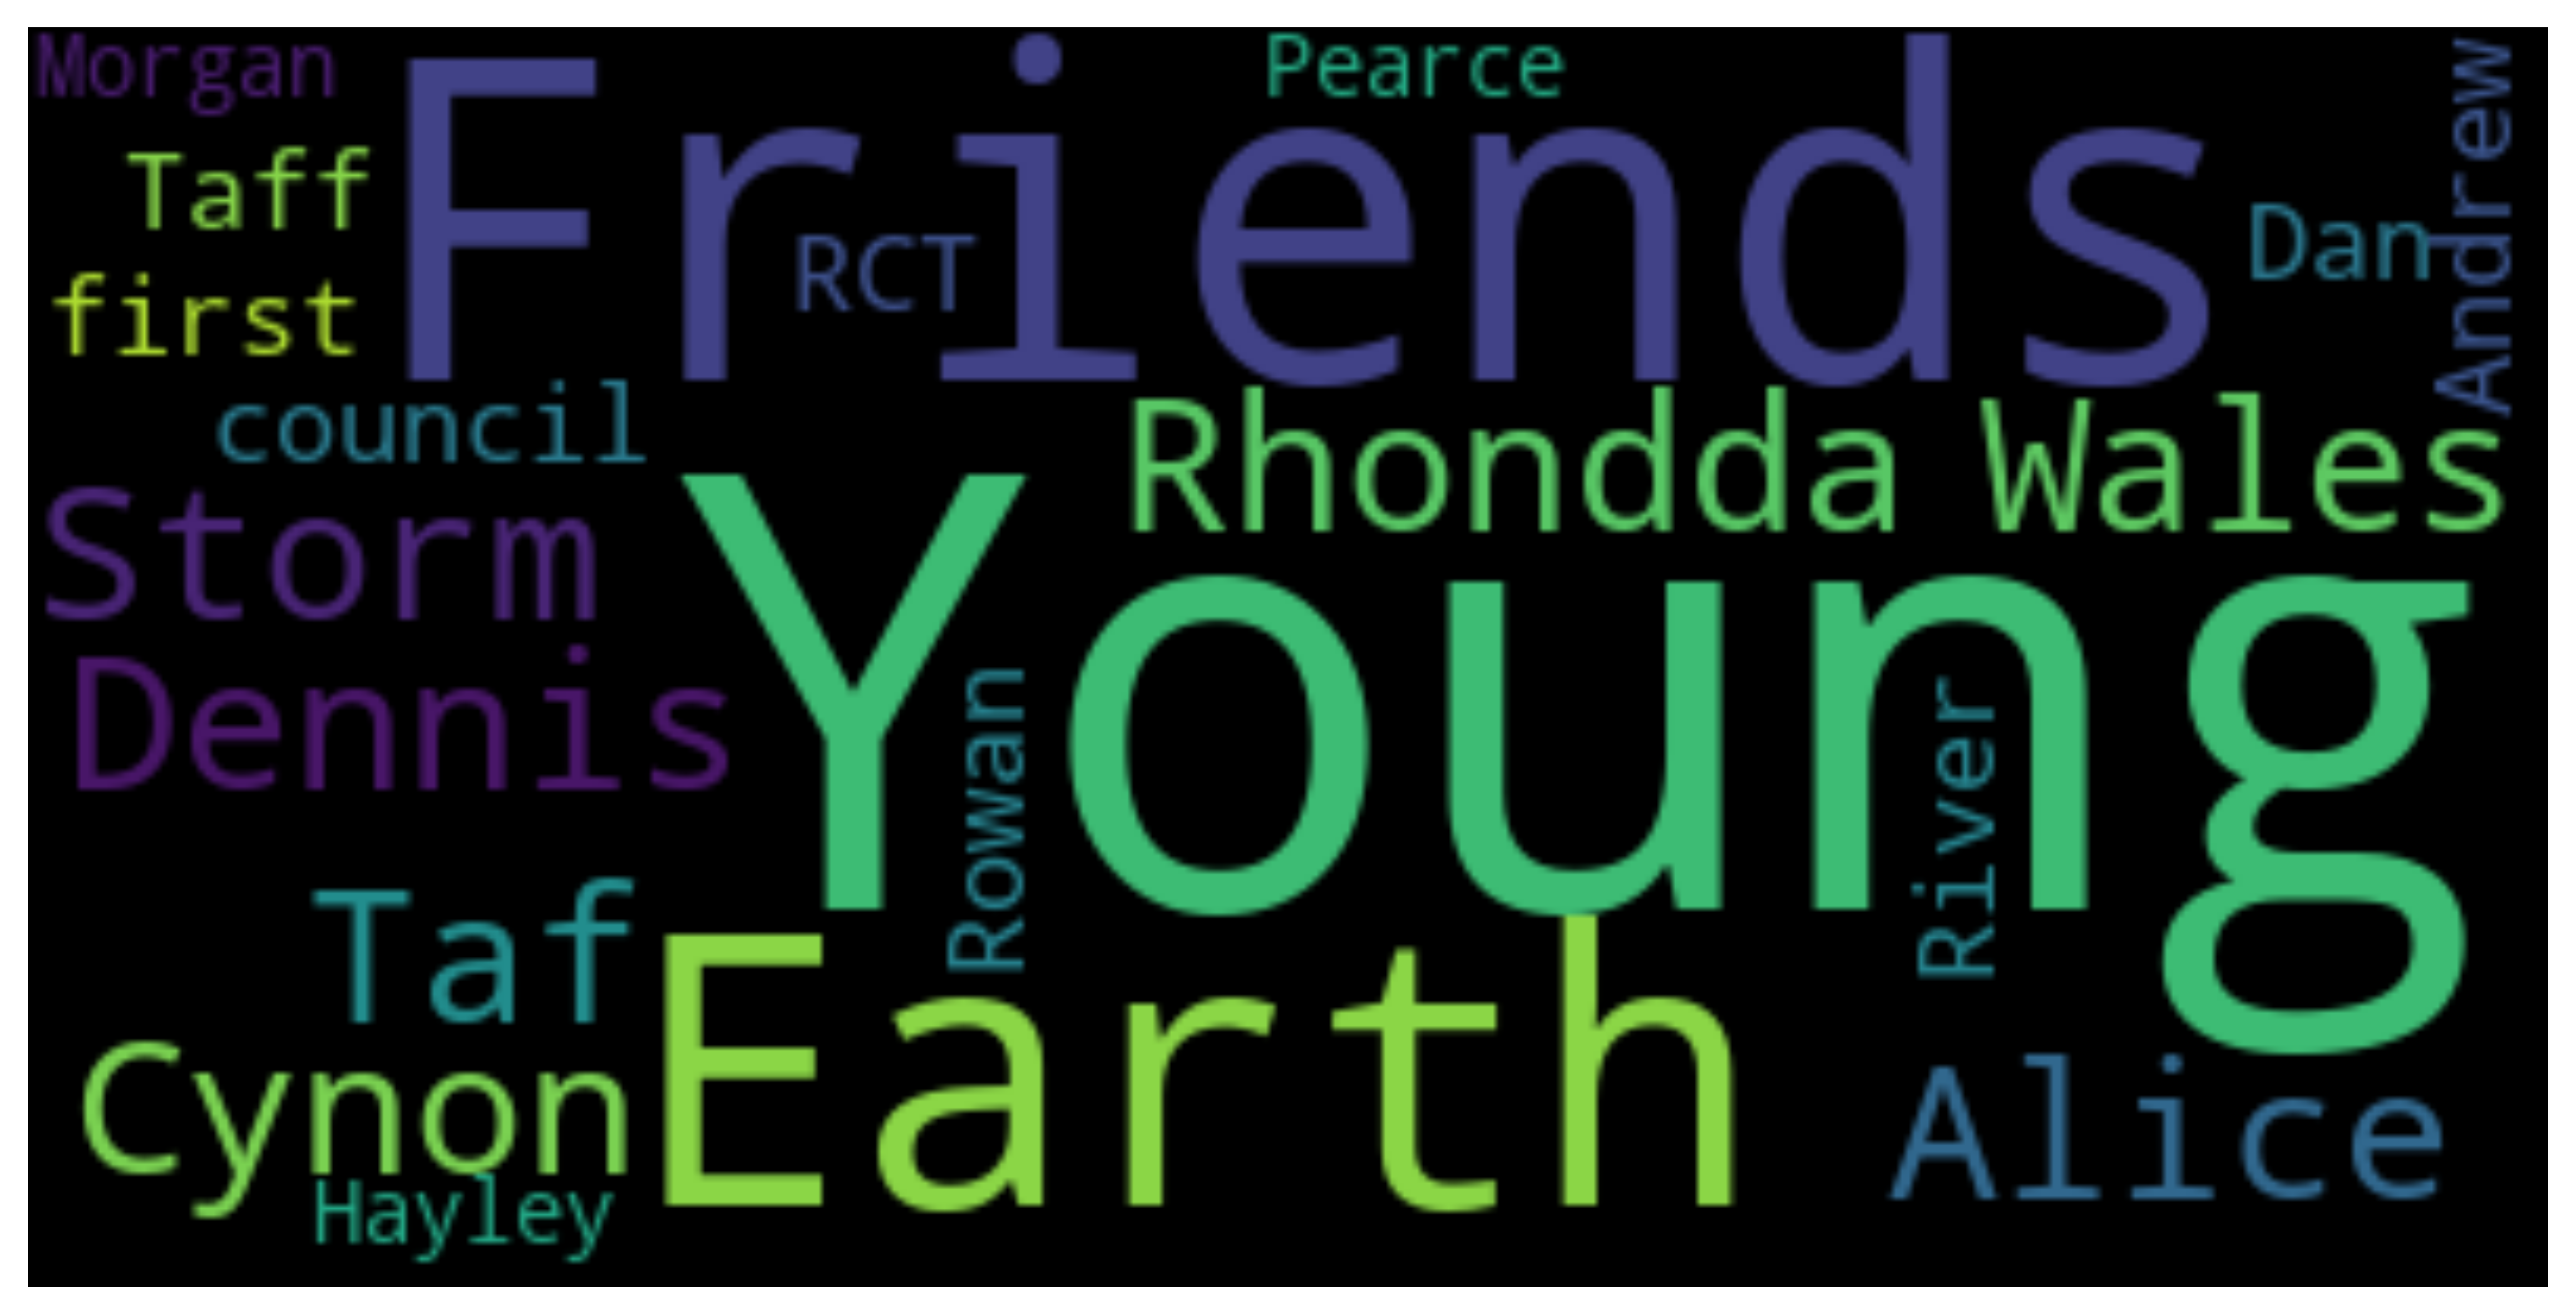

In [89]:
#illustration of NER words, might give a general idea
text = ' '.join([str(i) for i in data_entities_2['Entities'].to_list()])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(500)
plt.show()


In [90]:
#fetch for results using a google api.
def NE_info_fetch(named_entity):
    url = "https://google-search26.p.rapidapi.com/search"
    Ne = named_entity
    querystring = {"q":Ne,"hl":"en","tbs":"qdr:a",'as_sitesearch':'wikipedia.com'}

    headers = {
        'x-rapidapi-host': "google-search26.p.rapidapi.com",
        'x-rapidapi-key': "ea42e2dcc0msh49ecba51860383ep18d94ejsnbb0488e12e70"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    return (response.json()['results'][0]['snippet'][:200])

In [92]:
def get_summary(named_entity,data_unclean):
    def sumarize(List):
        result = []
        for _ in List:
            url = "https://api.meaningcloud.com/summarization-1.0"
            querystring = {"txt":_,"of":"json",'key':'1fe6342e2cfafb085d01802a50c98e6d','limit': 10}
            response = requests.request("GET", url, params=querystring)
            result.append(response.json()['summary'])
        return results
    data_unclean['article_content'] = data_unclean["article_content"].map(lambda x: x.lower())
    text = str(data_unclean.iloc[8]['article_content'])
    phrases = nltk.tokenize.sent_tokenize(text)
    results = []
    for _ in phrases:
        if named_entity in _ :
            results.append(_)
    return sumarize(results)
get_summary('andrew morgan',data_unclean)

['council leader andrew morgan replied to a letter from the group declining the award, saying the council is committed to achieving net zero by 2030 and "has already made progress towards achieving this commitment to meet and contribute to global, national and local targets".']

In [93]:
tok = nlp(NE_info_fetch('andrew morgan'))

In [95]:
tok = nlp(NE_info_fetch('andrew morgan'))
svos =printDeps(tok)
svos
selected_svos = []
for _ in svos:
    if _[2] in ['PROPN','VERB','NOUN']:
        try:
            selected_svos.append(_)
        except:
            pass
print(selected_svos)


[['Andrew', 'compound', 'PROPN', 'Richard', [], []], ['Richard', 'nmod', 'PROPN', 'Morgan', ['Andrew'], []], ['Drew', 'nmod', 'PROPN', 'Morgan', [], []], ['Morgan', 'nsubj', 'PROPN', 'is', ['Richard', '"', 'Drew', '"'], ['(', 'born', ')']], ['born', 'acl', 'VERB', 'Morgan', [], ['February']], ['February', 'npadvmod', 'PROPN', 'born', [], ['5', ',', '1976']], ['NASA', 'compound', 'PROPN', 'astronaut', [], []], ['astronaut', 'attr', 'NOUN', 'is', ['a', 'NASA'], ['from']], ['class', 'pobj', 'NOUN', 'from', ['the'], ['of']], ['Contents', 'ROOT', 'NOUN', 'Contents', [], ['.']], ['life', 'ROOT', 'NOUN', 'life', ['1', 'Personal'], [';', 'life', ',', ',', 'life', ',', '·', ',', 'career']], ['life', 'conj', 'NOUN', 'life', ['2', 'Early'], ['and', 'education', '\xa0', '...']], ['education', 'conj', 'NOUN', 'life', [], []], ['life', 'appos', 'NOUN', 'life', ['Early'], ['and', 'education']], ['education', 'conj', 'NOUN', 'life', [], []], ['US', 'compound', 'PROPN', 'Army', [], []], ['Army', 'compo

In [37]:
from neo4j import GraphDatabase, basic_auth
driver = GraphDatabase.driver("bolt://44.201.6.245:7687",auth=basic_auth("neo4j", "surplus-convulsion-handlers"))

cypher_query = '''
MATCH (c:Person{name:$name})-[r:INTERACTS]->(other)
  RETURN other.name as person
'''

with driver.session(database="neo4j") as session:
    results = session.read_transaction(lambda tx: tx.run(cypher_query,name="Jaime Lannister").data())
    for record in results:
        return record['person']

driver.close()

Josmyn Peckledon
Jonos Bracken
Tytos Blackwood
Tyrion Lannister
Kevan Lannister
Robert Baratheon
Vargo Hoat
Joy Hill
Wylis Manderly
Ronnet Connington
Shadrich
Mace Tyrell
Tyrion Lannister
Josmyn Peckledon
Pycelle
Lyle Crakehall
Rhaegar Targaryen
Shitmouth
Lewys Piper
Robb Stark
Melara Hetherspoon
Pia
Rennifer Longwaters
Ryman Frey
Olenna Redwyne
Renly Baratheon
Varys
Thoros
Karyl Vance
Qyburn
Tywin Lannister
Osmund Kettleblack
Margaery Tyrell
Lancel Lannister
Rafford
Tommen Baratheon
Walder Rivers
Robert Baratheon
Mariya Darry
Sandor Clegane
Sansa Stark
Zollo
Sybell Spicer
Walder Frey
Taena of Myr
Kevan Lannister
Loras Tyrell
Rorge
Walton
Shagwell
Osmund Kettleblack
Lem
Vargo Hoat
Robb Stark
Robert Baratheon
Roose Bolton
Tommen Baratheon
Oberyn Martell
Qyburn
Robin Ryger
Joffrey Baratheon
Tywin Lannister
Sansa Stark
Urswyck
Thoros
Meryn Trant
Tyrion Lannister
Loras Tyrell
Varys
Lysa Arryn
Stannis Baratheon
Rickard Karstark
Renly Baratheon
Robert Baratheon
Theon Greyjoy
Tywin Lannister
